# Cosmological structure

Here, we use `twinLab` to create an emulator for the statistical properties of the distribution of structure across the Universe.

The large-scale distribution of billions of galaxies contains a wealth of information about the origin, expansion, and contents of the Universe. For example, the galaxy distribution is sensitive to the amounts of dark energy and dark matter, the current and historial expansion speed, and the process of inflation that occurred soon after the big bang and which seeded the diverse array of cosmological structure, including all galaxies, stars and planets, that we see today. Galaxies exist in dense clumps, called groups, clusters, super clusters, depending on the number, at the nodes of the density distribution. The underlying density is governed by the dynamics and properties of dark matter, which defines a skeleton along which galaxies flow and eventually cluster.

To extract cosmological information from the galaxy distribution requires precise models of the statistical properties of the distribution as a function of the underlying parameters. Analytical theories, developed over the last 30 years, work at early times and on extremely large scales, where perturbations to the mean density are small. However, on the (comparatively small) scale of galaxies, the perturbations are huge and modelling their distribution can only be accurately achieved using expensive $n$-body simulations (the image above shows a slice of density through one such simulation). High-fidelity simulations can take up to a month to run distributed across tens of thousands of cores on the top super computers in the world. It is impractical to run accurate simulations at all points in parameter space, especially since the parameter-space of models under investigation is always expanding. In modern cosmology this includes the space of exotic dark energy models, beyond-Einstein gravity theories, and non-standard particle physics models for dark matter and neutrinos.

In this example, we use `twinLab` to create an emulator for the matter power spectrum, a statistical quantity that contains a subset of the possible information from the clustering distribution of galaxies. The power spectrum can both be computed via simulation and measured in observational datasets. The training of the `twinLab` emulator is performed online (in the cloud) and is completed in a matter of minutes. Once trained, the emulator can be used for extremely rapid power-spectrum evaluation across parameter space in a way that interpolates and extrapolates reasonably. The major benefit of using `twinLab` is that we get an accurate estimate of our model uncertainty for free, so that we know exactly how much we should trust our trained surrogate. The model is trained on approximate simulation data that occupy a Latin-hypercube distribution across five parameters of interest to cosmologists. The model can be rapidly retrained if necessary, and additional parameters can be incorporated if desired.

## Configuration

Import th libraries and the `twinLab` client with. Note that We need to supply our credentials to use `twinLab`, and these should be in a `.env` file in the project root directory.

In [1]:
# Standard imports
import os
from pprint import pprint

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# twinLab
import twinlab as tl


      == Client Initialisation ==
      Local Server  : http://localhost:3000
      Cloud Server  : https://z2seun1aee.execute-api.eu-west-2.amazonaws.com/Prod
      Group Name    : digilab
      User Name     : mead
      


In [2]:
# Campaign
CAMPAIGN_ID = "cosmology"

# Data options
POWER_RATIO = True
POWER_LOG = True
POWER_LATIN = True
TRAINING_POINTS = 100
SVD_VARIANCE = 0.9999

# Data files
TRAINING_FILEBASE = "cosmo"
EVALUATION_FILEBASE = "eval"
GRID_DATA = "grid.csv"

# Directories
CAMPAIGN_DIR = "./resources/campaigns/cosmology"
DATASETS_DIR = "./resources/datasets"

In [3]:
latin_thing = '_latin' if POWER_LATIN else ''
ratio_thing = '_ratio' if POWER_RATIO else ''
log_thing = '_log' if POWER_LOG else ''

TRAINING_DATA = TRAINING_FILEBASE+latin_thing+ratio_thing+log_thing+".csv"
EVALUATION_DATA = EVALUATION_FILEBASE+ratio_thing+log_thing+".csv"

# File paths
DATASET_PATH = os.path.join(DATASETS_DIR, TRAINING_DATA)
EVALUATION_PATH = os.path.join(CAMPAIGN_DIR, EVALUATION_DATA)
GRID_PATH = os.path.join(CAMPAIGN_DIR, GRID_DATA)

# Write to screen
print(f"Grid........ {GRID_PATH}")
print(f"Dataset..... {DATASET_PATH}")
print(f"Evaluate.... {EVALUATION_PATH}")

Grid........ ./resources/campaigns/cosmology/grid.csv
Dataset..... ./resources/datasets/cosmo_latin_ratio_log.csv
Evaluate.... ./resources/campaigns/cosmology/eval_ratio_log.csv


Ensure that the correct group and user names are reported.
These are used to track client usage.

## Run

### Upload dataset

We'll use the csv data in `resources/datasets/cosmology.csv` to train our emulator:

In [4]:
tl.upload_dataset(DATASET_PATH)

### List datasets

Check which datasets are avalible to train with:

In [5]:
datasets = tl.list_datasets()
pprint(datasets)

['cosmo_latin_ratio_log.csv',
 'cosmo_random.csv',
 'cosmology_latin_small.csv',
 'cosmology_random_small.csv']


### View dataset statistics

You can query the dataset to provide a statistical summary:

In [6]:
df = tl.query_dataset(TRAINING_DATA)
display(df)

,z,Omega_c,Omega_b,Omega_k,h,ns,sigma_8,w0,wa,m_nu,...,k90,k91,k92,k93,k94,k95,k96,k97,k98,k99
count,100,100.000000,100.000000,100,100.000000,100.000000,100.000000,100,100,100,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0,0.250000,0.045000,0,0.700000,0.960000,0.800000,-1,0,0,...,3.281836,3.352583,3.421395,3.488363,3.553550,3.616989,3.678705,3.738718,3.797048,3.853713
std,0,0.029011,0.005802,0,0.116046,0.029011,0.058023,0,0,0,...,0.162057,0.161426,0.160766,0.160086,0.159401,0.158729,0.158089,0.157502,0.156990,0.156557
min,0,0.200500,0.035100,0,0.502000,0.910500,0.701000,-1,0,0,...,2.972049,3.046222,3.118395,3.188731,3.257329,3.323588,3.385952,3.446596,3.505519,3.562695
25%,0,0.225250,0.040050,0,0.601000,0.935250,0.750500,-1,0,0,...,3.141016,3.213130,3.283365,3.351844,3.419504,3.484086,3.547615,3.607494,3.666973,3.724364
50%,0,0.250000,0.045000,0,0.700000,0.960000,0.800000,-1,0,0,...,3.287803,3.359563,3.429386,3.497368,3.563570,3.628025,3.690569,3.748817,3.805019,3.859474
75%,0,0.274750,0.049950,0,0.799000,0.984750,0.849500,-1,0,0,...,3.402966,3.474712,3.542359,3.609780,3.676947,3.741665,3.804458,3.864770,3.922585,3.976823
max,0,0.299500,0.054900,0,0.898000,1.009500,0.899000,-1,0,0,...,3.726312,3.794816,3.861157,3.925443,3.987783,4.048299,4.107122,4.164369,4.220120,4.274397


### Training

Set the emulator training parameters:

In [7]:
# Set parameters
nk = 100
cosmological_parameters = ["Omega_c", "Omega_b", "h", "ns", "sigma_8"]
wavenumber_columns = [f"k{i}" for i in range(nk)]
params = {
    "filename": TRAINING_DATA,
    "inputs": cosmological_parameters,
    "outputs": wavenumber_columns,
    "decompose_outputs": True,
    "output_explained_variance": SVD_VARIANCE,
    "train_test_split": TRAINING_POINTS,
}
pprint(params, compact=True, sort_dicts=False)

{'filename': 'cosmo_latin_ratio_log.csv',
 'inputs': ['Omega_c', 'Omega_b', 'h', 'ns', 'sigma_8'],
 'outputs': ['k0', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10',
             'k11', 'k12', 'k13', 'k14', 'k15', 'k16', 'k17', 'k18', 'k19',
             'k20', 'k21', 'k22', 'k23', 'k24', 'k25', 'k26', 'k27', 'k28',
             'k29', 'k30', 'k31', 'k32', 'k33', 'k34', 'k35', 'k36', 'k37',
             'k38', 'k39', 'k40', 'k41', 'k42', 'k43', 'k44', 'k45', 'k46',
             'k47', 'k48', 'k49', 'k50', 'k51', 'k52', 'k53', 'k54', 'k55',
             'k56', 'k57', 'k58', 'k59', 'k60', 'k61', 'k62', 'k63', 'k64',
             'k65', 'k66', 'k67', 'k68', 'k69', 'k70', 'k71', 'k72', 'k73',
             'k74', 'k75', 'k76', 'k77', 'k78', 'k79', 'k80', 'k81', 'k82',
             'k83', 'k84', 'k85', 'k86', 'k87', 'k88', 'k89', 'k90', 'k91',
             'k92', 'k93', 'k94', 'k95', 'k96', 'k97', 'k98', 'k99'],
 'decompose_outputs': True,
 'output_explained_variance': 0.9999,
 

Train the emulator:

In [8]:
tl.train_campaign(params, CAMPAIGN_ID)

Check which campaigns are ready with:

In [9]:
campaigns = tl.list_campaigns()
pprint(campaigns)

['cosmology']


View the metadata of an emulator with:

In [10]:
query = tl.query_campaign(CAMPAIGN_ID)
pprint(query, compact=True)

{'calibration_error': None,
 'diagnostics': {'estimator_diagnostics': {'base_estimator_diagnostics': {'covar_module.base_kernel.lengthscale_prior.concentration': 3.0,
                                                                          'covar_module.base_kernel.lengthscale_prior.rate': 6.0,
                                                                          'covar_module.base_kernel.raw_lengthscale': [[[2.3309569644303596,
                                                                                                                         4.245643053539296,
                                                                                                                         2.2789607144393766,
                                                                                                                         3.043893075029445,
                                                                                                                         3.0683998187292927]]

### Sample

Sample the trained emulator with:

In [11]:
df_eval_mean, df_eval_std = tl.sample_campaign(EVALUATION_PATH, CAMPAIGN_ID)
df_train_mean, df_train_std = tl.sample_campaign(DATASET_PATH, CAMPAIGN_ID)

Read in the evaluation data and the grid of $k$ values on which to evaluate $P(k)$

In [12]:
df_train = pd.read_csv(DATASET_PATH)
df_grid = pd.read_csv(GRID_PATH)
df_eval = pd.read_csv(EVALUATION_PATH)

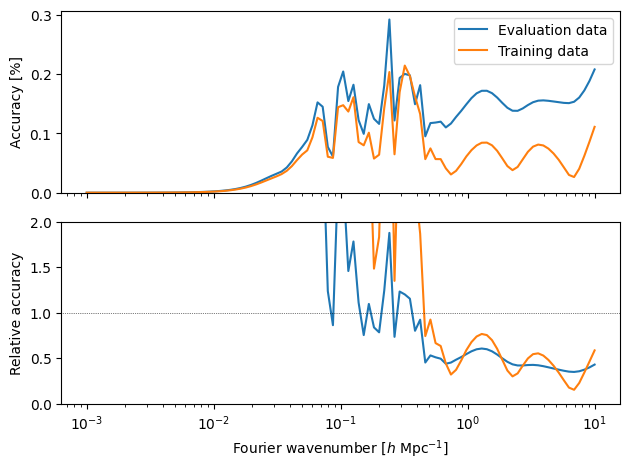

In [13]:
# Accuracy statistics
if POWER_LOG: # Note that the difference is appropriate here because the data may be log
    accuracy_eval = (df_eval_mean[wavenumber_columns]-df_eval[wavenumber_columns]).std()
    accuracy_train = (df_train_mean[wavenumber_columns]-df_train[wavenumber_columns]).std()
else:
    accuracy_eval = (df_eval_mean[wavenumber_columns]/df_eval[wavenumber_columns]-1.).std()
    accuracy_train = (df_train_mean[wavenumber_columns]/df_train[wavenumber_columns]-1.).std()

plt.subplots(2, 1, sharex=True)

# Accuracy of model
plt.subplot(2, 1, 1)
plt.plot(df_grid.iloc[0].values, 100.*accuracy_eval, label='Evaluation data')
plt.plot(df_grid.iloc[0].values, 100.*accuracy_train, label='Training data')
plt.xscale("log")
plt.ylabel("Accuracy [%]")
plt.ylim(bottom=0.)
plt.legend()

# Accuracy of preicted error
plt.subplot(2, 1, 2)
plt.plot(df_grid.iloc[0].values, accuracy_eval/df_eval_std.iloc[0].values)
plt.plot(df_grid.iloc[0].values, accuracy_train/df_train_std.iloc[0].values)
plt.xscale("log")
plt.xlabel(r"Fourier wavenumber [$h$ Mpc$^{-1}$]")
plt.axhline(1., color="k", linestyle=":", lw=0.5)
plt.ylabel("Relative accuracy")
plt.ylim((0., 2.))

plt.tight_layout()
plt.show()

Error magnification factor: 10.0 



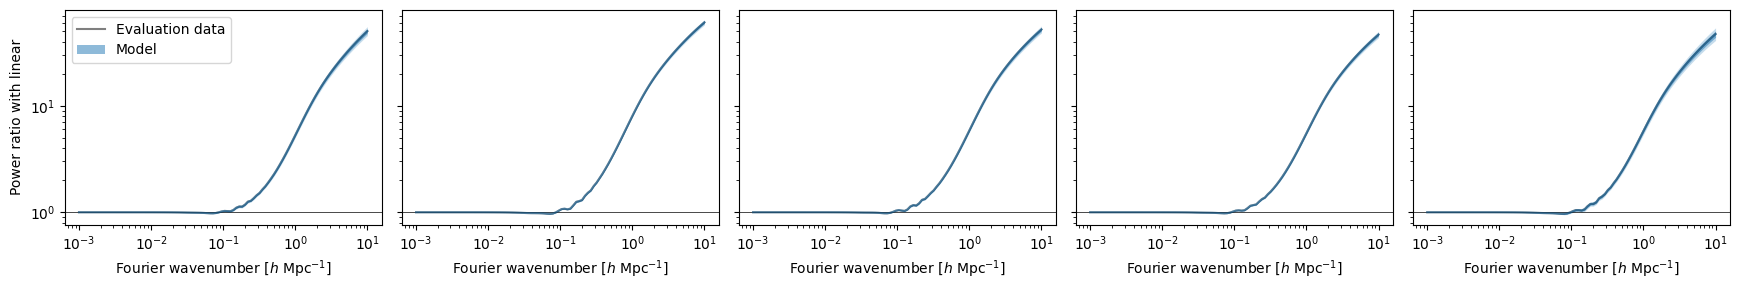

In [14]:
# Plotting parameters
nsig = [1, 2]  # sigma errors to plot
mfac = 10.  # Factor to inflate error bars by
alpha_data = 0.5
alpha_model = 0.5
color_model = "C0"
plot_band = True
plot_mean = True
npow = 5

print(f"Error magnification factor: {mfac} \n")

# Plot power
plt.subplots(1, npow, figsize=(npow*3.5, 3.), sharex=True, sharey=True)
grid = df_grid.iloc[0].values
for i in range(npow):
    plt.subplot(1, npow, i+1)
    if POWER_RATIO:
        plt.axhline(1., color="black", lw=0.5)
    eval = df_eval[wavenumber_columns].iloc[i].values
    mean = df_eval_mean.iloc[i].values
    err = df_eval_std.iloc[i].values
    if POWER_LOG:
        eval, mean = np.exp(eval), np.exp(mean)
    label = "Evaluation data" if i==0 else None
    plt.plot(grid, eval, color="black", alpha=alpha_data, label=label)
    if plot_band:
        for sig in nsig:
            if POWER_LOG:
                ymin, ymax = np.exp(-mfac*sig*err), np.exp(mfac*sig*err)
                ymin, ymax = mean*ymin, mean*ymax
            else:
                ymin, ymax = -mfac*sig*err, mfac*sig*err
                ymin, ymax = mean+ymin, mean+ymax
            label = "Model" if sig==nsig[0] else None
            plt.fill_between(grid, ymin, ymax, color=color_model, lw=0., alpha=alpha_model/sig, label=label)
    if plot_mean:
        label  = "Model" if not plot_band else None
        plt.plot(grid, mean, color=color_model, alpha=alpha_model, label=label)
    plt.xlabel(r"Fourier wavenumber [$h$ Mpc$^{-1}$]")
    plt.xscale("log")
    if i==0: 
        if POWER_RATIO:
            plt.ylabel(r"Power ratio with linear")
        else:
            plt.ylabel(r"Power spectrum [$(h^{-1}\mathrm{Mpc})^3$]")
        plt.legend()
    plt.yscale("log")
plt.tight_layout()
plt.show()

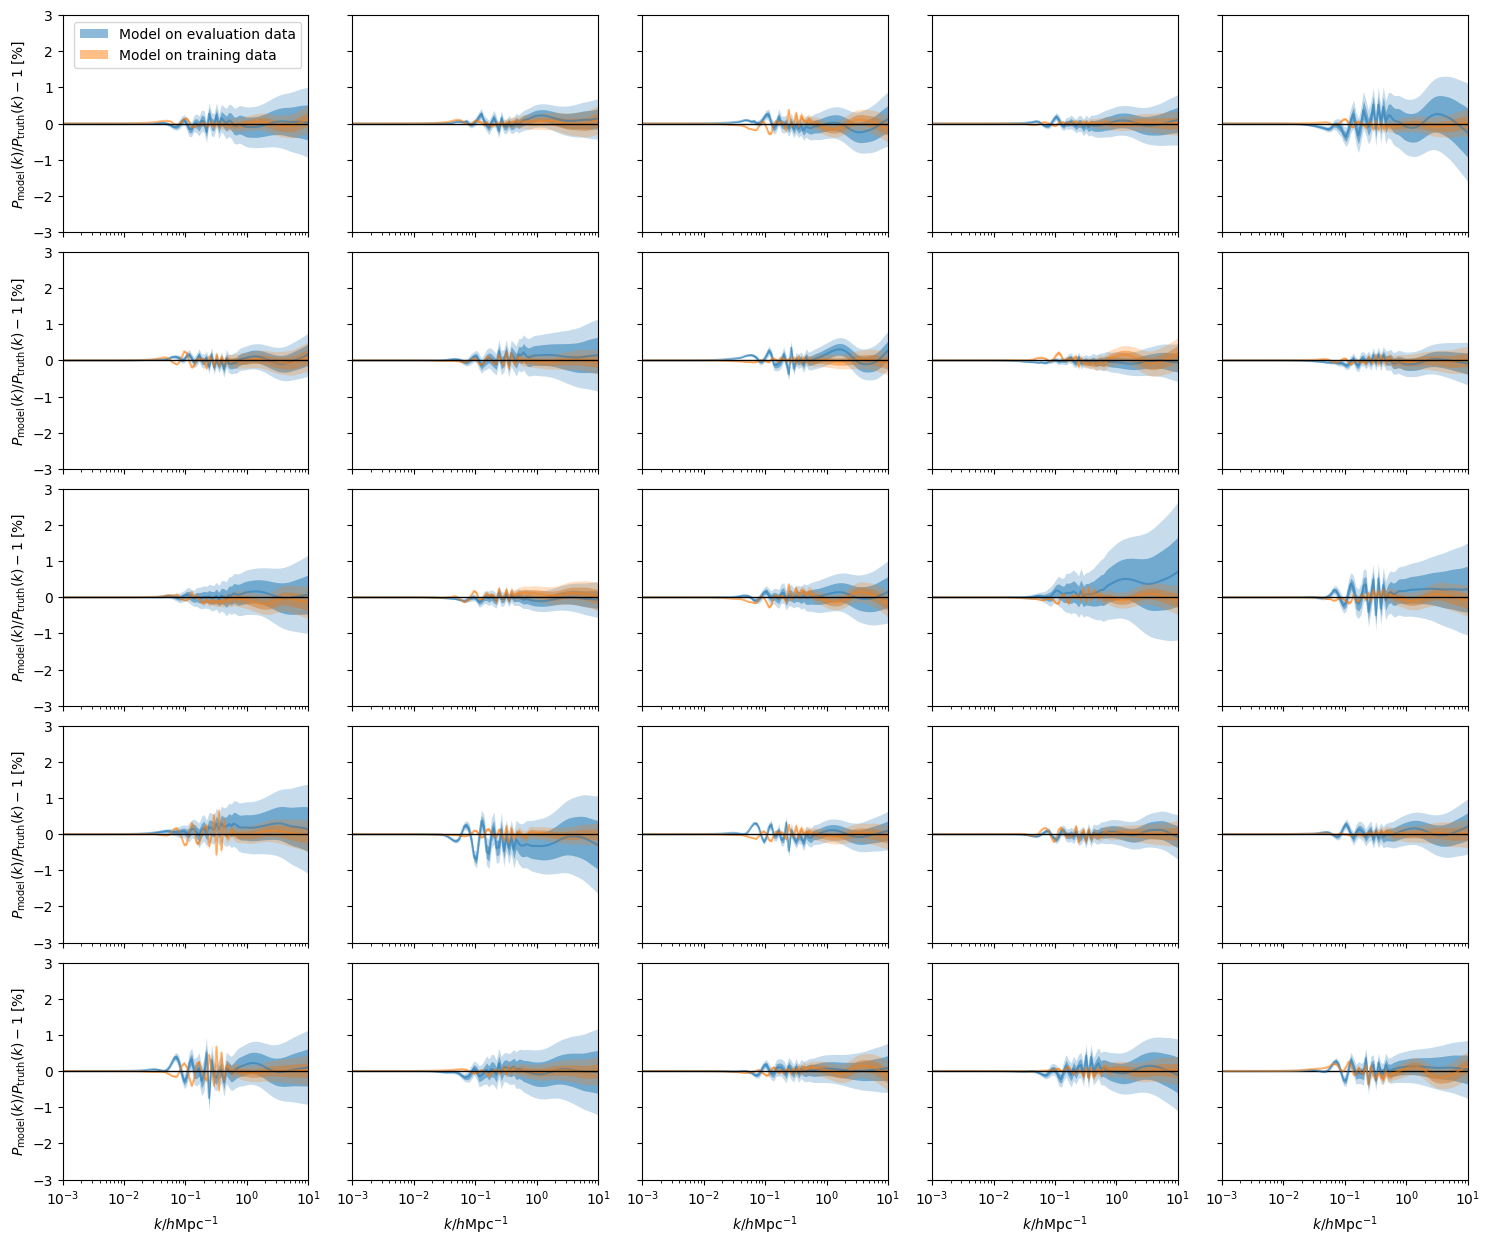

In [15]:
# Parameters
nsig = [1, 2]
alpha_data = 0.5
alpha_model = 0.5
color_model = "C0"
plot_train = True
alpha_train = 0.5
color_train = "C1"
dr = 3.
plot_band = True
plot_mean = True
ncos = 25
nrow = 5

# Calculations
ncol = ncos//nrow

# Plot
grid = df_grid.iloc[0].values
plt.subplots(nrow, ncol, figsize=(3*ncol, 2.5*nrow), sharex=True, sharey=True)
for i in range(ncos):
    plt.axhline(0., color="black", lw=1)
    plt.subplot(nrow, ncol, i+1)
    eval = df_eval[wavenumber_columns].iloc[i].values
    eval_mean = df_eval_mean.iloc[i].values
    eval_err = df_eval_std.iloc[i].values
    train = df_train[wavenumber_columns].iloc[i].values
    train_mean = df_train_mean.iloc[i].values
    train_err = df_train_std.iloc[i].values
    if POWER_LOG:
        eval, eval_mean = np.exp(eval), np.exp(eval_mean)
        train, train_mean = np.exp(train), np.exp(train_mean)
    if plot_band:
        for sig in nsig:
            if POWER_LOG:
                ymin, ymax = np.exp(-sig*eval_err), np.exp(sig*eval_err)
                ymin, ymax = 100.*((eval_mean*ymin)/eval-1.), 100.*((eval_mean*ymax)/eval-1.)
            else:
                ymin, ymax = -sig*eval_err, sig*eval_err
                ymin, ymax = 100.*((eval_mean+ymin)/eval-1.), 100.*((eval_mean+ymax)/eval-1.)
            label = "Model on evaluation data" if sig==nsig[0] else None
            plt.fill_between(grid, ymin, ymax, color=color_model, lw=0, alpha=alpha_model/sig, label=label)
            if plot_train:
                if POWER_LOG:
                    ymin, ymax = np.exp(-sig*train_err), np.exp(sig*train_err)
                    ymin, ymax = 100.*((train_mean*ymin)/train-1.), 100.*((train_mean*ymax)/train-1.)
                else:
                    ymin, ymax = -sig*train_err, sig*train_err
                    ymin, ymax = 100.*((train_mean+ymin)/train-1.), 100.*((train_mean+ymax)/train-1.)
                label = "Model on training data" if sig==nsig[0] else None
                plt.fill_between(grid, ymin, ymax, color=color_train, lw=0, alpha=alpha_train/sig, label=label)
    if plot_mean:
        label = "Model on evaluation data" if not plot_band else None
        y = 100.*(eval_mean/eval-1.)
        plt.plot(grid, y, color=color_model, alpha=alpha_model, label=label)
        if plot_train:
            label = "Model on training data" if not plot_band else None
            y = 100.*(train_mean/train-1.)
            plt.plot(grid, y, color=color_train, alpha=alpha_train, label=label)
    if i//ncol==nrow-1: plt.xlabel(r"$k/h\mathrm{Mpc}^{-1}$")
    plt.xscale("log")
    plt.xlim((grid[0], grid[-1]))
    if i%ncol==0: plt.ylabel(r"$P_\mathrm{model}(k)/P_\mathrm{truth}(k)-1$ [%]")
    plt.ylim((-dr, dr))
    if i==0: plt.legend()
plt.tight_layout()
plt.show()

Finally, delete a trained emulator and the dataset if necessary

In [16]:
tl.delete_campaign(CAMPAIGN_ID)
tl.delete_dataset(TRAINING_DATA)